In [1]:
import numpy as np
import os
import sys

import torch
from torch import nn
from torchsummary import summary

import importlib

import matplotlib.pyplot as plt
from IPython import display

sys.path.insert(0, "../src/")
import data
import model

np.random.seed(11)

In [2]:
def plot_X(X, y, figsize=(16,6), n_row=2, n_col=3, n_show=4, file=None):
    
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    for i in range(n_show):
        if X.dim() == 4:
            axs[i].plot(X[i, :, 0, :].T)
        else:
            axs[i].plot(X[i].T)
        if y is not None:
            axs[i].plot(y[i, 0], "r")
        
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

In [3]:
def live_plot_nb(y_out, y_std, y_trg, step, n_steps, loss, lr, figsize=(16,6), n_row=1, n_col=2, n_show=2, show_loss=True, log=False, file=None):
    
    n_pts = y_out.shape[-1]
    
    display.clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    for i in range(n_show):
        axs[i].plot(y_trg[i, 0])
        axs[i].plot(y_out[i, 0])
        axs[i].fill_between(range(n_pts), y_out[i, 0] - y_std[i, 0], y_out[i, 0] + y_std[i, 0], facecolor="r", alpha=0.1)

    if show_loss:
        axs[i+1].plot(loss)
        axs[i+1].plot(np.argmin(loss), np.min(loss), "ro")
        axs[i+2].plot(lrs)
    
    if log:
        axs[i+1].set_xscale("log")
        axs[i+1].set_yscale("log")
        axs[i+2].set_xscale("log")
        axs[i+2].set_yscale("log")
    
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

# Define data generation parameters

In [4]:
data_pars = dict(
                 # General parameters
                 td = 256, # Number of points
                 Fs = 12800, # Sampling frequency
                 debug = False, # Print data generation details

                 # Peak parameters
                 pmin = 1, # Minimum number of Gaussians in a peak
                 pmax = 1, # Maximum number of Gaussians in a peak
                 ds = 0.03, # Spread of chemical shift values for each peak
                 lw = [[5e1, 2e2], [1e2, 2e3]], # Linewidth range for Gaussians
                 iso_p = [0.9, 0.1],
                 iso_p_peakwise = True,
                 phase = 0., # Spread of phase

                 # Isotropic parameters
                 nmin = 1, # Minimum number of peaks
                 nmax = 15, # Maximum number of peaks
                 shift_range = [2000., 10000.], # Chemical shift range
                 positive = True, # Force the spectrum to be positive

                 # MAS-dependent parameters
                 mas_g_range = [[1e10, 1e11], [1e10, 5e11]], # MAS-dependent Gaussian broadening range
                 mas_l_range = [[1e7, 1e8], [1e7, 5e8]], # MAS-dependent Lorentzian broadening range
                 mas_s_range = [[-1e7, 1e7], [-1e7, 1e7]], # MAS-dependent shift range
                 mas_p = [0.9, 0.1],
                 mas_phase = 0.1, # Random phase range for MAS spectra
                 peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                 encode_imag = False, # Encode the imaginary part of the MAS spectra
                 nw = 16, # Number of MAS rates
                 mas_w_range = [30000, 100000], # MAS rate range
                 random_mas = True,
                 encode_w = True, # Encode the MAS rate of the spectra

                 # Post-processing parameters
                 noise = 0., # Noise level
                 smooth_end_len = 10, # Smooth ends of spectra
                 scale_iso = 0.8, # Scale isotropic spectra
                 offset = 0., # Baseline offset
                 norm_wr = True, # Normalize MAS rate values
                 wr_inv = False # Encode inverse of MAS rate instead of MAS rate
                )

loss_pars = dict(srp_w = 1.,
                 srp_exp = 1.,
                 srp_offset = 1.,
                 srp_fac = 100.,
                 
                 brd_w = 0.,
                 brd_sig = 5.,
                 brd_len = 25,
                 brd_exp = 2.,
                 brd_offset = 1.,
                 brd_fac = 0.
                )

model_pars = dict(n_models = 5,
                  input_dim = 2,
                  hidden_dim = 16,
                  kernel_size = [[5, 5, 5], [5, 5, 5], [7, 7, 7], [7, 7, 7], [9, 9, 9]],
                  num_layers = 3,
                  final_kernel_size = 1,
                  batch_input = 4,
                  bias = True,
                  final_bias = True,
                  return_all_layers = True,
                 )

fig_dir = "../figures/ensemble_lstm_sanity_check_multiscale/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [5]:
dataset = data.PIPDataset(**data_pars)

# Get training data (4 samples)

In [6]:
n_samples = 4
X = []
P = []
y = []

for i in range(n_samples):
    xi, pi, yi = dataset.__getitem__(i)
    X.append(torch.unsqueeze(xi, 0))
    y.append(torch.unsqueeze(yi, 0))
    P.append(torch.unsqueeze(pi, 0))

X = torch.cat(X)
y = torch.cat(y)
P = torch.cat(P)

ys = [torch.unsqueeze(y.clone(), 0) for _ in range(model_pars["n_models"])]

ys = torch.cat(ys, dim=0)

#plot_X(X, None, file=fig_dir + "inputs.pdf")
#plot_X(X, y, file=fig_dir + "inputs_with_trg.pdf")
#plot_X(P, None, file=fig_dir + "input_peaks.pdf")

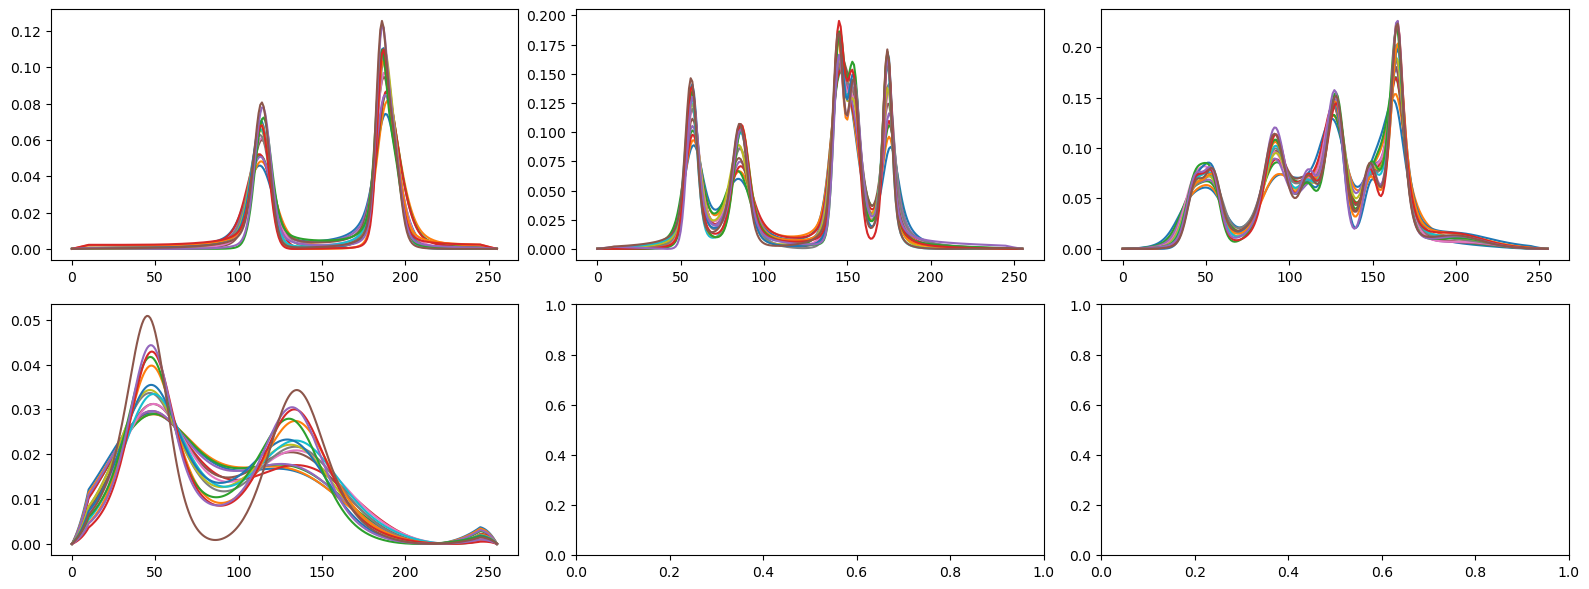

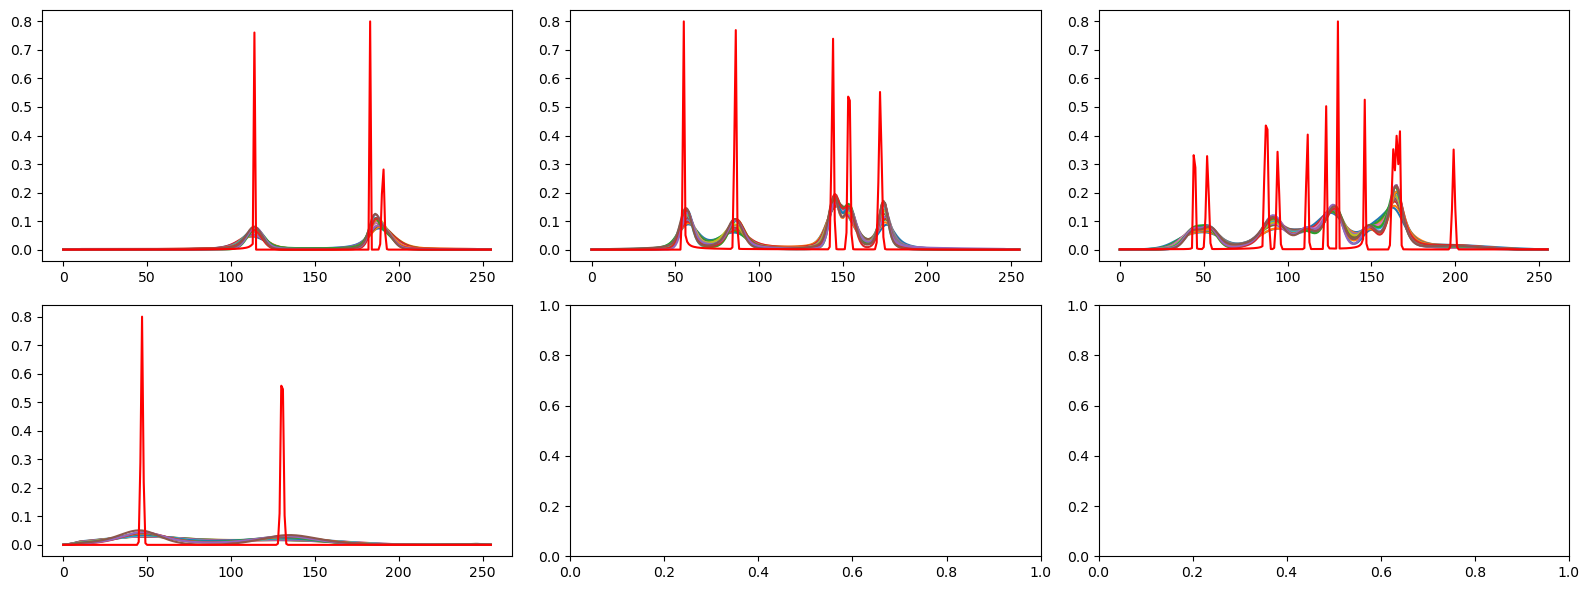

In [7]:
plot_X(X, None, file=fig_dir + "inputs.pdf")
plot_X(X, y, file=fig_dir + "inputs_with_trg.pdf")

# Define network, loss and optimizer

In [8]:
importlib.reload(model)

<module 'model' from '../src/model.py'>

In [9]:
net = model.ConvLSTMEnsemble(**model_pars)
L = model.CustomLoss(**loss_pars)
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=50)

# Train the model

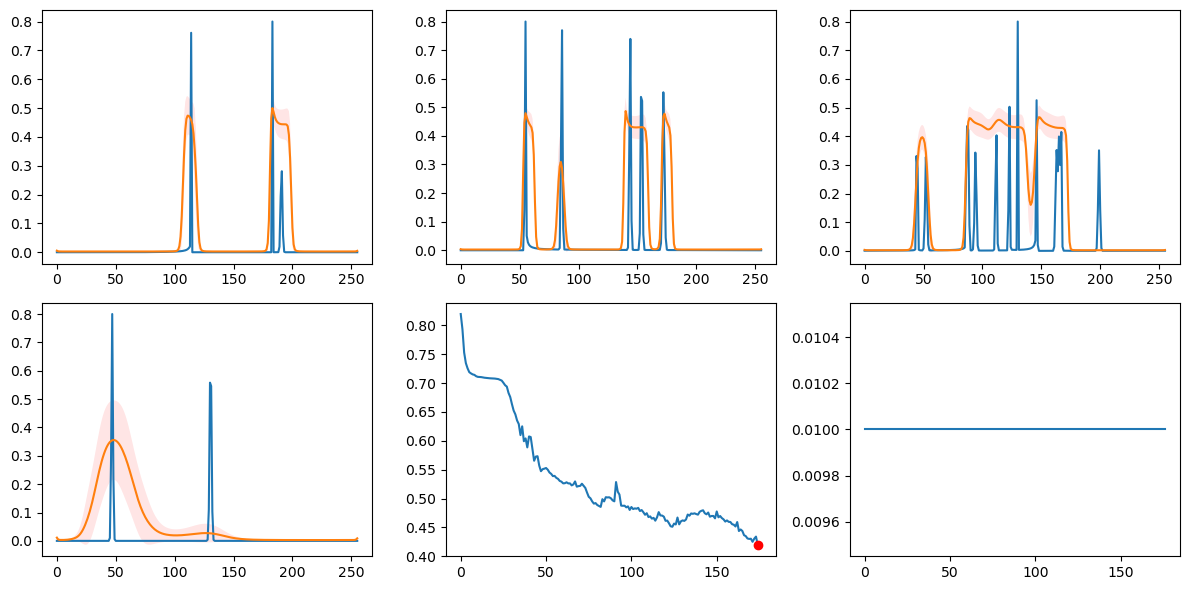

178/5000


In [ ]:
n_train = 5000

net.train()

ymax = torch.max(y)

losses = []
lrs = []

for i in range(n_train):
    
    print("{}/{}".format(i+1, n_train))
    
    net.zero_grad()
    
    output, std, ys_pred = net(X)
    
    loss = L(ys_pred, ys)
    
    loss.backward()
    
    losses.append(float(loss.detach()))
    
    opt.step()
    
    sch.step(loss)
    
    lrs.append(opt.param_groups[0]["lr"])
    live_plot_nb(output.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4)

# Second training with updated loss

In [ ]:
net2 = model.ConvLSTMEnsemble(**model_pars)
net2.load_state_dict(net.state_dict())
L2 = model.CustomLoss(exp=1., offset=1., factor=10., out_factor=0.)
opt2 = torch.optim.Adam(net2.parameters(), lr=1e-3)
sch2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt2, factor=0.5, patience=50)

# Train the model

In [ ]:
n_train = 5000

net2.train()

ymax = torch.max(y)

losses = []
lrs = []

for i in range(n_train):
    
    print("{}/{}".format(i+1, n_train))
    
    net2.zero_grad()
    
    output, std, ys_pred = net2(X)
    
    loss = L2(ys_pred, ys)
    
    loss.backward()
    
    losses.append(float(loss.detach()))
    
    opt2.step()
    
    sch2.step(loss)
    
    lrs.append(opt.param_groups[0]["lr"])
    live_plot_nb(output.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4)

# Evaluate the model on the training data

In [ ]:
%%time

net.eval()

output, std, _ = net(X)

In [ ]:
live_plot_nb(output.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check.pdf")
live_plot_nb(output.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, log=True, file=fig_dir + "sanity_check_log.pdf")

In [ ]:
%%time

net2.eval()

output, std, _ = net2(X)

In [ ]:
live_plot_nb(output.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_2.pdf")
live_plot_nb(output.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, log=True, file=fig_dir + "sanity_check_2_log.pdf")

# Evaluate model with partial input

In [ ]:
for n in range(4, 16):
    X2 = X[:, :n].clone()
    
    output, std, _ = net(X2)
    
    live_plot_nb(output.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_first_{}_spectra.pdf".format(n))

In [ ]:
for n in range(4, 16):
    X2 = X[:, :n].clone()
    
    output, std, _ = net2(X2)
    
    live_plot_nb(output.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_first_{}_spectra_2.pdf".format(n))

# Add noise to the data

In [ ]:
for noise in [0.0001, 0.001, 0.01]:
    
    X2 = X.clone()
    X2 += torch.randn(X2.shape) * noise
    X2 -= torch.min(X2, dim=3)[0].unsqueeze(-1)
    
    plot_X(X2, None, file=fig_dir + "inputs_noise_{}.pdf".format(noise))
    plot_X(X2, y, file=fig_dir + "inputs_noise_{}_with_trg.pdf".format(noise))
    
    y2, std, _ = net(X2)
    
    live_plot_nb(y2.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_noise_{}.pdf".format(noise))

In [ ]:
for noise in [0.0001, 0.001, 0.01]:
    
    X2 = X.clone()
    X2 += torch.randn(X2.shape) * noise
    X2 -= torch.min(X2, dim=3)[0].unsqueeze(-1)
    
    plot_X(X2, None, file=fig_dir + "inputs_noise_{}.pdf".format(noise))
    plot_X(X2, y, file=fig_dir + "inputs_noise_{}_with_trg.pdf".format(noise))
    
    y2, std, _ = net2(X2)
    
    live_plot_nb(y2.detach(), std.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_noise_{}_2.pdf".format(noise))

# Generate another batch of data for testing

In [ ]:
n_samples = 4
X = []
y = []

for i in range(n_samples):
    xi, _, yi = dataset.__getitem__(i)
    X.append(torch.unsqueeze(xi, 0))
    y.append(torch.unsqueeze(yi, 0))

X = torch.cat(X)
y = torch.cat(y)

plot_X(X, None, file=fig_dir + "inputs_oos.pdf")
plot_X(X, y, file=fig_dir + "inputs_oos_with_trg.pdf")

In [ ]:
%%time

output, _, _ = net(X)

In [ ]:
live_plot_nb(output.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_oos.pdf")

In [ ]:
%%time

output, _, _ = net2(X)

In [ ]:
live_plot_nb(output.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_oos_2.pdf")

In [ ]:
L(output, y)

In [ ]:
for n in range(3, 10):
    X2 = X[:, :n].clone()
    
    output, _, _ = net(X2)
    
    live_plot_nb(output.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_oos_first_{}_spectra.pdf".format(n))

# Add noise to the data

In [ ]:
for noise in [0.001, 0.01, 0.1]:
    
    X2 = X.clone()
    X2 += torch.randn(X2.shape) * noise
    X2 -= torch.min(X2, dim=3)[0].unsqueeze(-1)
    
    plot_X(X2, None, file=fig_dir + "inputs_oos_noise_{}.pdf".format(noise))
    plot_X(X2, y, file=fig_dir + "inputs_oos_noise_{}_with_trg.pdf".format(noise))
    
    y2, _, _ = net(X2)
    
    live_plot_nb(y2.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_oos_noise_{}.pdf".format(noise))
    
    print(L(y2, y))

# Generate random MAS data

In [ ]:
data_pars2 = dict(nmin = 1, # Minimum number of peaks
                  nmax = 10, # Maximum number of peaks
                  shift_range = [1., 9.], # Chemical shift range
                  lw1_range = [0., 0.005], # Isotropic broadening range
                  gen_lw2 = True,
                  lw2_range = [0.1, 0.5], # Second isotropic broadening range
                  asym = False, # Generate asymmetric shifts
                  mas_g_range = [0., 1e5], # MAS-dependent Gaussian broadening range
                  mas_l_range = [0., 5e4], # MAS-dependent Lorentzian broadening range
                  mas_s_range = [-1e4, 1e4], # MAS-dependent shift range
                  nw = 9, # Number of MAS rates
                  mas_w_range = [30000, 100000], # MAS rate range
                  random_mas = True,
                  encode_w = False,
                  td = 512,
                  Fs = 10,
                  noise = 0.,
                  smooth_end_len = 10,
                  scale_iso = 0.8,
                  offset = 0.,
                  norm_wr = True,
                  wr_inv = False
                 )

In [ ]:
dataset2 = data.PIPDataset(**data_pars2)

In [ ]:
n_samples = 4
X = []
y = []

for i in range(n_samples):
    xi, _, yi = dataset2.__getitem__(i)
    X.append(torch.unsqueeze(xi, 0))
    y.append(torch.unsqueeze(yi, 0))

X = torch.cat(X)
y = torch.cat(y)

plot_X(X, None, file=fig_dir + "inputs_rand_w_oos.pdf")
plot_X(X, y, file=fig_dir + "inputs_rand_w_oos_with_trg.pdf")

In [ ]:
%%time

output, _, _ = net(X)

In [ ]:
live_plot_nb(output.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_rand_w_oos.pdf")

In [ ]:
for n in range(3, 10):
    X2 = X[:, :n].clone()
    
    output, _, _ = net(X2)
    
    live_plot_nb(output.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_rand_w_oos_first_{}_spectra.pdf".format(n))

In [ ]:
for noise in [0.001, 0.01, 0.1]:
    
    X2 = X.clone()
    X2 += torch.randn(X2.shape) * noise
    X2 -= torch.min(X2, dim=3)[0].unsqueeze(-1)
    
    plot_X(X2, None, file=fig_dir + "inputs_rand_w_oos_noise_{}.pdf".format(noise))
    plot_X(X2, y, file=fig_dir + "inputs_rand_w_oos_noise_{}_with_trg.pdf".format(noise))
    
    y2, _, _ = net(X2)
    
    live_plot_nb(y2.detach(), y, i, n_train, losses, lrs, figsize=(12,6), n_row=2, n_col=3, n_show=4, file=fig_dir + "sanity_check_rand_w_oos_noise_{}.pdf".format(noise))

In [ ]:
plt.loglog(lrs)

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot(y[0])
ax.plot(output.detach().numpy()[0])

In [ ]:
i = 1
plt.plot(y[i])
plt.plot(output.detach().numpy()[i])

In [ ]:
i = 0
plt.plot(X[i, :, 0, :].T)
plt.plot(output.detach().numpy()[i], "r")

In [ ]:
i = 1
plt.plot(X[i, :, 0, :].T)
plt.plot(output.detach().numpy()[i], "r")

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
%%time

brd_specs, specs, iso = dataset.__getitem__(0)

In [ ]:
iso.shape

In [ ]:
plt.plot(specs.T)

In [ ]:
plt.plot(brd_specs[:, 0, :].T)
plt.plot(iso, "r")

In [ ]:
plt.plot(iso)

In [ ]:
%%time

fids, specs = gen_individual_iso_spectra(shifts, lw1, dataset.t, lw2=lw2, asym=dataset.asym, a=a)

In [ ]:
plt.plot(specs.T)

In [ ]:
shifts, lw1, lw2, a = dataset.gen_shifts()
print(len(shifts))

In [ ]:
def generate_data(batch_size, p_point_broadening, nmin, nmax, shift_range, lw1_range, nw,
                  mas_w_range, mas_g_range, mas_l_range, mas_s_range, t, Fs, gen_lw2=False, lw2_range=None, asym=False):
    
    X = []
    y = []
    w = []
    
    for _ in range(batch_size):

        # Generate isotropic shifts
        shifts, lw1, lw2, a = gen_shifts(nmin, nmax, shift_range=shift_range, lw1_range=lw1_range, gen_lw2=gen_lw2, lw2_range=lw2_range, asym=asym)

        # Select MAS rates
        dw = mas_w_range[1]-mas_w_range[0]
        w0 = mas_w_range[0]
        wr = np.sort(np.random.rand(nw)) * dw + w0
        
        print(wr)
        
        dl = mas_l_range[1]-mas_l_range[0]
        l0 = mas_l_range[0]
        
        dg = mas_g_range[1]-mas_g_range[0]
        g0 = mas_g_range[0]
        
        ds = mas_s_range[1]-mas_s_range[0]
        s0 = mas_s_range[0]

        if np.random.rand() < p_point_broadening:
            print("Point-wise")
            # Point-wise broadening
            _, iso = gen_iso_spectrum(shifts, lw1, t, lw2=lw2, asym=asym, a=a)
            
            this_mas_g = np.random.rand() * dg + g0
            this_mas_l = np.random.rand() * dl + l0
            
            _, specs, _, _, _ = gen_mas_broadening(iso, t, Fs, wr, [this_mas_g, this_mas_g],
                                                              [this_mas_l, this_mas_l], mas_s_range)
            
        else:
            print("Peak-wise")
            # Peak-wise broadening
            _, isos = gen_individual_iso_spectra(shifts, lw1, t, lw2=lw2, asym=asym, a=a)
            
            all_specs = np.zeros((isos.shape[0], len(wr), isos.shape[1]))
            
            for i, iso in enumerate(isos):
                this_mas_g = np.random.rand() * dg + g0
                this_mas_l = np.random.rand() * dl + l0
                this_mas_s = np.random.rand() * ds + s0
                
                print(this_mas_s)
                
                _, all_specs[i], _, _, _ = gen_mas_broadening(iso, t, Fs, wr, [this_mas_g, this_mas_g],
                                                              [this_mas_l, this_mas_l], [this_mas_s, this_mas_s])
            
            iso = np.mean(isos, axis=0)
            specs = np.mean(all_specs, axis=0)
        
        X.append(specs)
        y.append(iso)
        w.append(wr)

    return np.array(X), np.array(y), np.array(w)

In [ ]:
%%time

X, y, w = generate_data(batch_size, p_point_broadening, nmin, nmax, shift_range, lw1_range, nw, mas_w_range,
                        mas_g_range, mas_l_range, mas_s_range, t, Fs, gen_lw2=gen_lw2, lw2_range=lw2_range, asym=asym)

In [ ]:
%%time

X, y, w = generate_data(batch_size, p_point_broadening, nmin, nmax, shift_range, lw1_range, nw, mas_w_range,
                        mas_g_range, mas_l_range, mas_s_range, t, Fs, gen_lw2=gen_lw2, lw2_range=lw2_range, asym=asym)

In [ ]:
for x, yi in zip(X, y):
    plt.plot(x.T)
    plt.plot(yi * 10, "r")
    plt.show()
    plt.close()

In [ ]:
for x, yi in zip(X, y):
    plt.plot(x.T)
    plt.plot(yi * 10, "r")
    plt.show()
    plt.close()

In [ ]:
w.shape

In [ ]:
_, iso = gen_iso_spectrum(shifts, lw1, t, lw2=lw2)

In [ ]:
plt.plot(iso)

In [ ]:
shifts

In [ ]:
plt.plot(isos.T)

In [ ]:
%%time

shifts, lw1, lw2, a = gen_shifts(nmin, nmax,
                                 shift_range=shift_range, lw1_range=lw1_range,
                                 gen_lw2=gen_lw2, lw2_range=lw2_range, asym=asym)

fid, iso = gen_iso_spectrum(shifts, lw1, t, lw2=lw2, asym=asym, a=a)



In [ ]:
shifts = np.array([8.0, 5.00, 3.00, 2.00])
lw1 = np.array([0.02, 0.05, 0.03, 0.01])*0.05
lw2 = np.array([4.00, 7.00, 4.60, 10.0])*0.05

td = 128
Fs = 10
tmax = td/Fs
t2 = np.arange(0, tmax, 1 / Fs)

In [ ]:
fid, spec = data.gen_iso_spectrum(shifts, lw1, t2, lw2=lw2)

In [ ]:
plt.plot(spec)

In [ ]:
testspec2 = np.ones(15) * 2
testspec2 = np.pad(testspec2, (75, 15))

temp = np.ones(10)

for i in range(10):
    temp[i] = temp[i] * (i + 1) / 2

testspec3 = np.concatenate((testspec2, temp), axis=0)
testspec3 = np.pad(testspec3, (0, 13), )

newspec = spec + testspec3
newspec -= np.min(newspec)

In [ ]:
plt.plot(newspec)

In [ ]:
wr=np.arange(20000, 108000, 8000)[:8]

In [ ]:
%%time
specs, data, _, _, _ = gen_mas_broadening(newspec, t2, Fs, wr, [60000, 60000], [20000, 20000], [-10000, -10000])

In [ ]:
plt.plot(data.T)